# A Hierarchical Model of Honeybee Waggle-Dances
Details
     AUTHOR:	James Foster              DATE: 2025 03 14
   MODIFIED:	James Foster              DATE: 2024 09 23

DESCRIPTION: Fit a hierarchical maximum-likelihood von Mises to honeybee waggle-run angles.
            
INPUTS: 
            
OUTPUTS: Plots and test statistics

CHANGES: - More comprehensive simulation

REFERENCES:
Sayin S, ... Graving JM, et al. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:10.1126/science.adq7832

Graving JM & Foster JJ in preparation
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

# First set up the required packages
Don't forget to make sure the the kernel is running in a `conda` environment.
To fit models using `g++` (recommended for speed) make sure `m2w64-toolchain` is installed on Windows.

In [ ]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain
##JJF on Mac install "ipywidgets" for Jupyter support of PyMC
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-rgp76g1c
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-rgp76g1c
  Resolved https://github.com/jgraving/unwrap to commit b158ec9cf3b6d06ed4c9baa721978c7a1ab1dd84
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 212.1 kB/s eta 0:00:0000:0100:04
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11525 sha256=ea77bef80f81e89b0d5a4510bbfec8c62a23475e880a46b4a9149d9d483e7448
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-3fdbc7u2/wheels/6d/a6/84/e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.0
    Uninstalling numpy-2.1.0:
      Successfu

# Prepare the data
## Import and format the data
Load the preprocessed data from CSV and convert to radians. Relabel the two conditions in each factor to binary.

In [30]:

import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'colour_dance_reorg.csv'#JJF windows is having trouble finding this file
df = pd.read_csv(file_path, sep=',')

# Create a binary indicator for the light intensity (1 for 'low', 0 for 'high')
df['B'] = df['brightn'].apply(lambda x: 1 if 'l' in x else 0)
# Create a binary indicator for the light colour (1 for 'UV', 0 for 'green')
df['C'] = df['colour'].apply(lambda x: 1 if 'u' in x else 0)
# Rename sun azimuth to use capitalised label
df['SunAz'] = df['sun_az_rad']
# Rename run to use capitalised label
df['Run'] = df['run']

# Convert the dance angle column to the correct format (already radians?)
df['angle'] = pd.to_numeric(df['angle'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN

# Normalise all angles to be between -pi and pi (should be already)
df['angle'] = df['angle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)
df['sun_az_rad'] = df['sun_az_rad'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['angle','ID', 'B', 'C', 'Run','SunAz']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'ID': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()

angle        Individual  B  C  Run     SunAz
0 -1.570796  2016.05.31.14.24  1  1    1 -2.647205
1  0.087266  2016.05.31.14.24  1  1    2 -2.647205
2  0.349066  2016.05.31.14.24  1  1    3 -2.647205
3 -0.698132  2016.05.31.14.24  1  1    4 -2.647205
4  0.349066  2016.05.31.14.24  1  1    5 -2.647205

## Inspect the data
Use Jake's plots to show the repeated angles across individuals.
Maybe limit this to just 10 individuals for now.

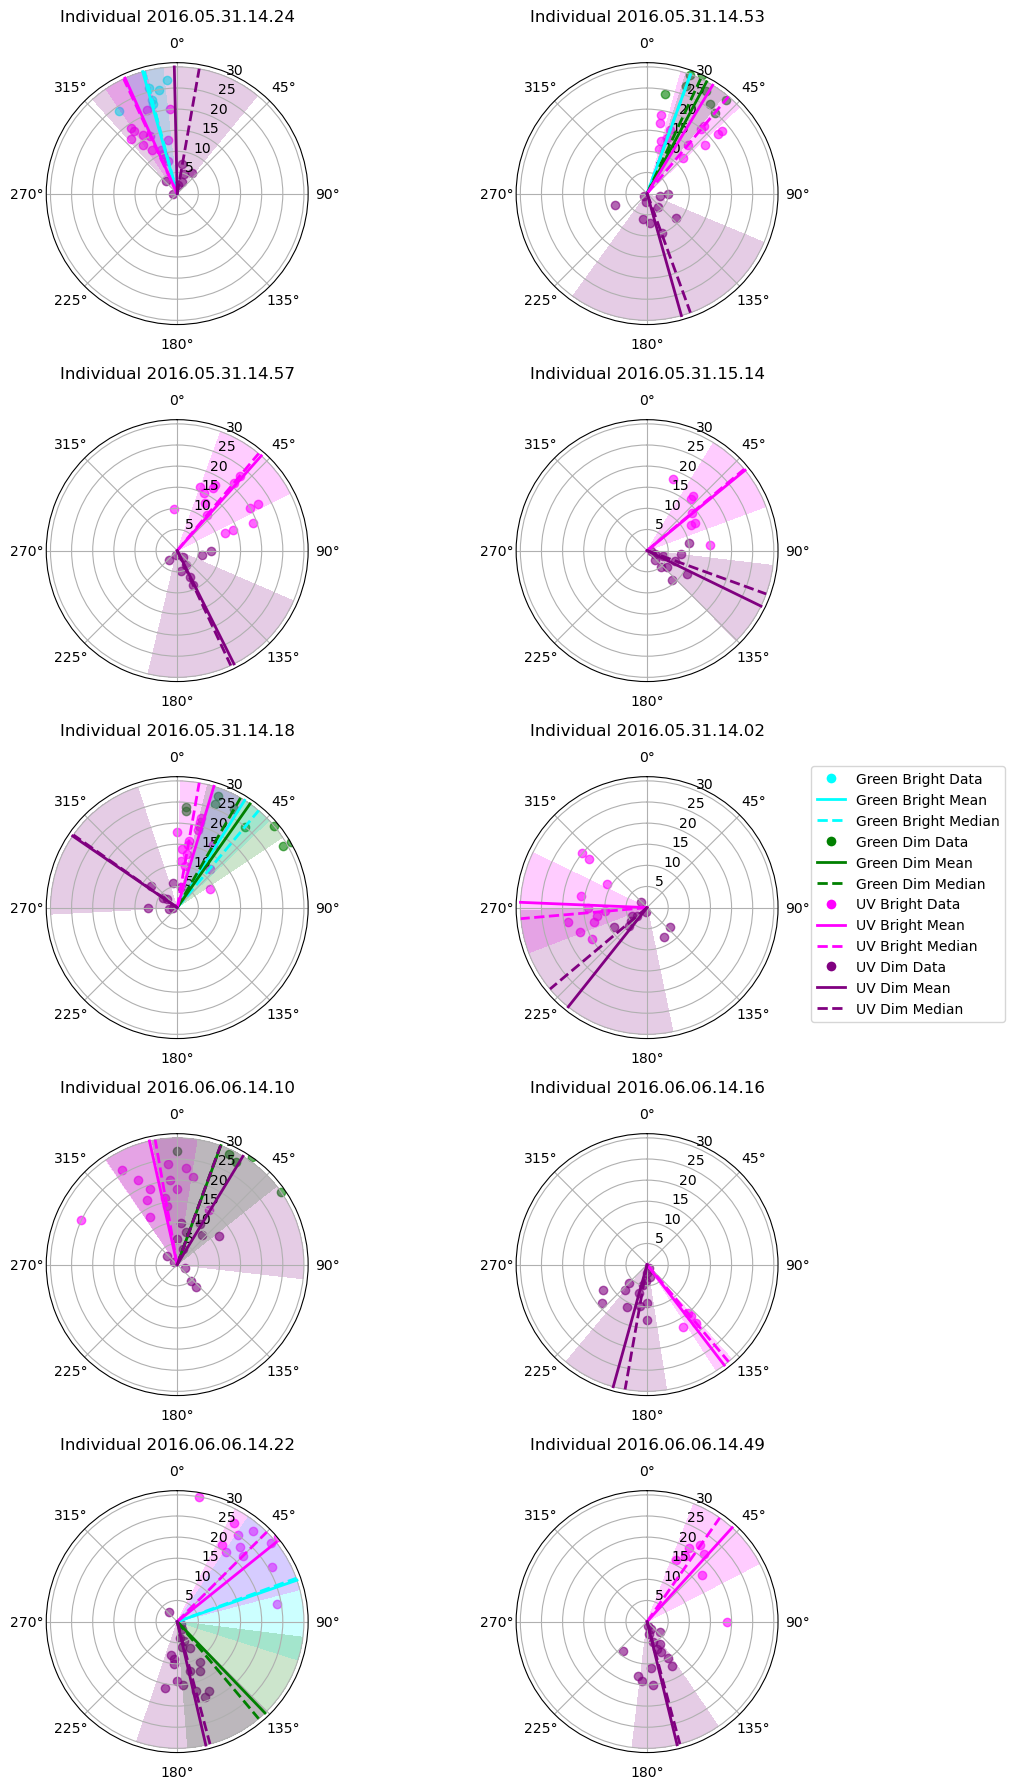

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[range(0,10)] # for now just the 1st 10

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10*3  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_direction(-1)#reverse to clockwise
    ax.set_theta_zero_location('N')#place 0° at the top
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light bright and Light dim data (drop NaNs in angle).
    data_on = individual_data[individual_data['B'] == 0].dropna(subset=['angle'])
    data_off = individual_data[individual_data['B'] == 1].dropna(subset=['angle'])
    # Separate bright data.
    data_gh = data_on[data_on['C'] == 0]
    data_uh = data_on[data_on['C'] == 1]
    # Separate dim data.
    data_gl = data_off[data_off['C'] == 0]
    data_ul = data_off[data_off['C'] == 1]
    
    # Scatter-plot data.
    plot_scatter(ax, data_gh, 'angle', 'run', 'cyan', 'Green Bright')
    plot_scatter(ax, data_gl, 'angle', 'run', 'green', 'Green Dim')
    plot_scatter(ax, data_uh, 'angle', 'run', 'magenta', 'UV Bright')
    plot_scatter(ax, data_ul, 'angle', 'run', 'purple', 'UV Dim')
    
    # Plot summary statistics for each condition.
    if not data_gh.empty:
        plot_summary_stats(ax, data_gh['angle'].values, radial_max, 'cyan')
    if not data_gl.empty:
        plot_summary_stats(ax, data_gl['angle'].values, radial_max, 'green')
    if not data_uh.empty:
        plot_summary_stats(ax, data_uh['angle'].values, radial_max, 'magenta')
    if not data_ul.empty:
        plot_summary_stats(ax, data_ul['angle'].values, radial_max, 'purple')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For green bright (cyan)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=8, label='Green Bright Data'),
    Line2D([0], [0], color='cyan', lw=2, label='Green Bright Mean'),
    Line2D([0], [0], color='cyan', lw=2, linestyle='--', label='Green Bright Median'),
    # For green dim (green)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Green Dim Data'),
    Line2D([0], [0], color='green', lw=2, label='Green Dim Mean'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Green Dim Median'),
    # For UV bright (magenta)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=8, label='UV Bright Data'),
    Line2D([0], [0], color='magenta', lw=2, label='UV Bright Mean'),
    Line2D([0], [0], color='magenta', lw=2, linestyle='--', label='UV Bright Median'),
    # For UV dim (purple)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='UV Dim Data'),
    Line2D([0], [0], color='purple', lw=2, label='UV Dim Mean'),
    Line2D([0], [0], color='purple', lw=2, linestyle='--', label='UV Dim Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()

# Fit a circular model with individual effects but no interactions
To begin with fit a model with only the effects of different individuals, light intensities and LED colours.

In [10]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "angle ~ B + C + (1 + B + C |Individual)",
    "kappa ~ B + C + (1 + B + C |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

# Fit the model.
idata = model.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!

       Formula: angle ~ B + C + (1 + B + C |Individual)
                kappa ~ B + C + (1 + B + C |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3142)
            C ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_B ~ Normal(mu: 0.0, sigma: 2.5)
            kappa_C ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset]


/opt/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 340 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Visualise output of simple model
This one doesn't include interaction terms.
The "Intercept" is the condition: Green, Bright
B is the effect dimming the light: Green, Dim
C is the effect of switching to UV: UV, Bright
The simple addition of effects for B and C would give: UV, Dim

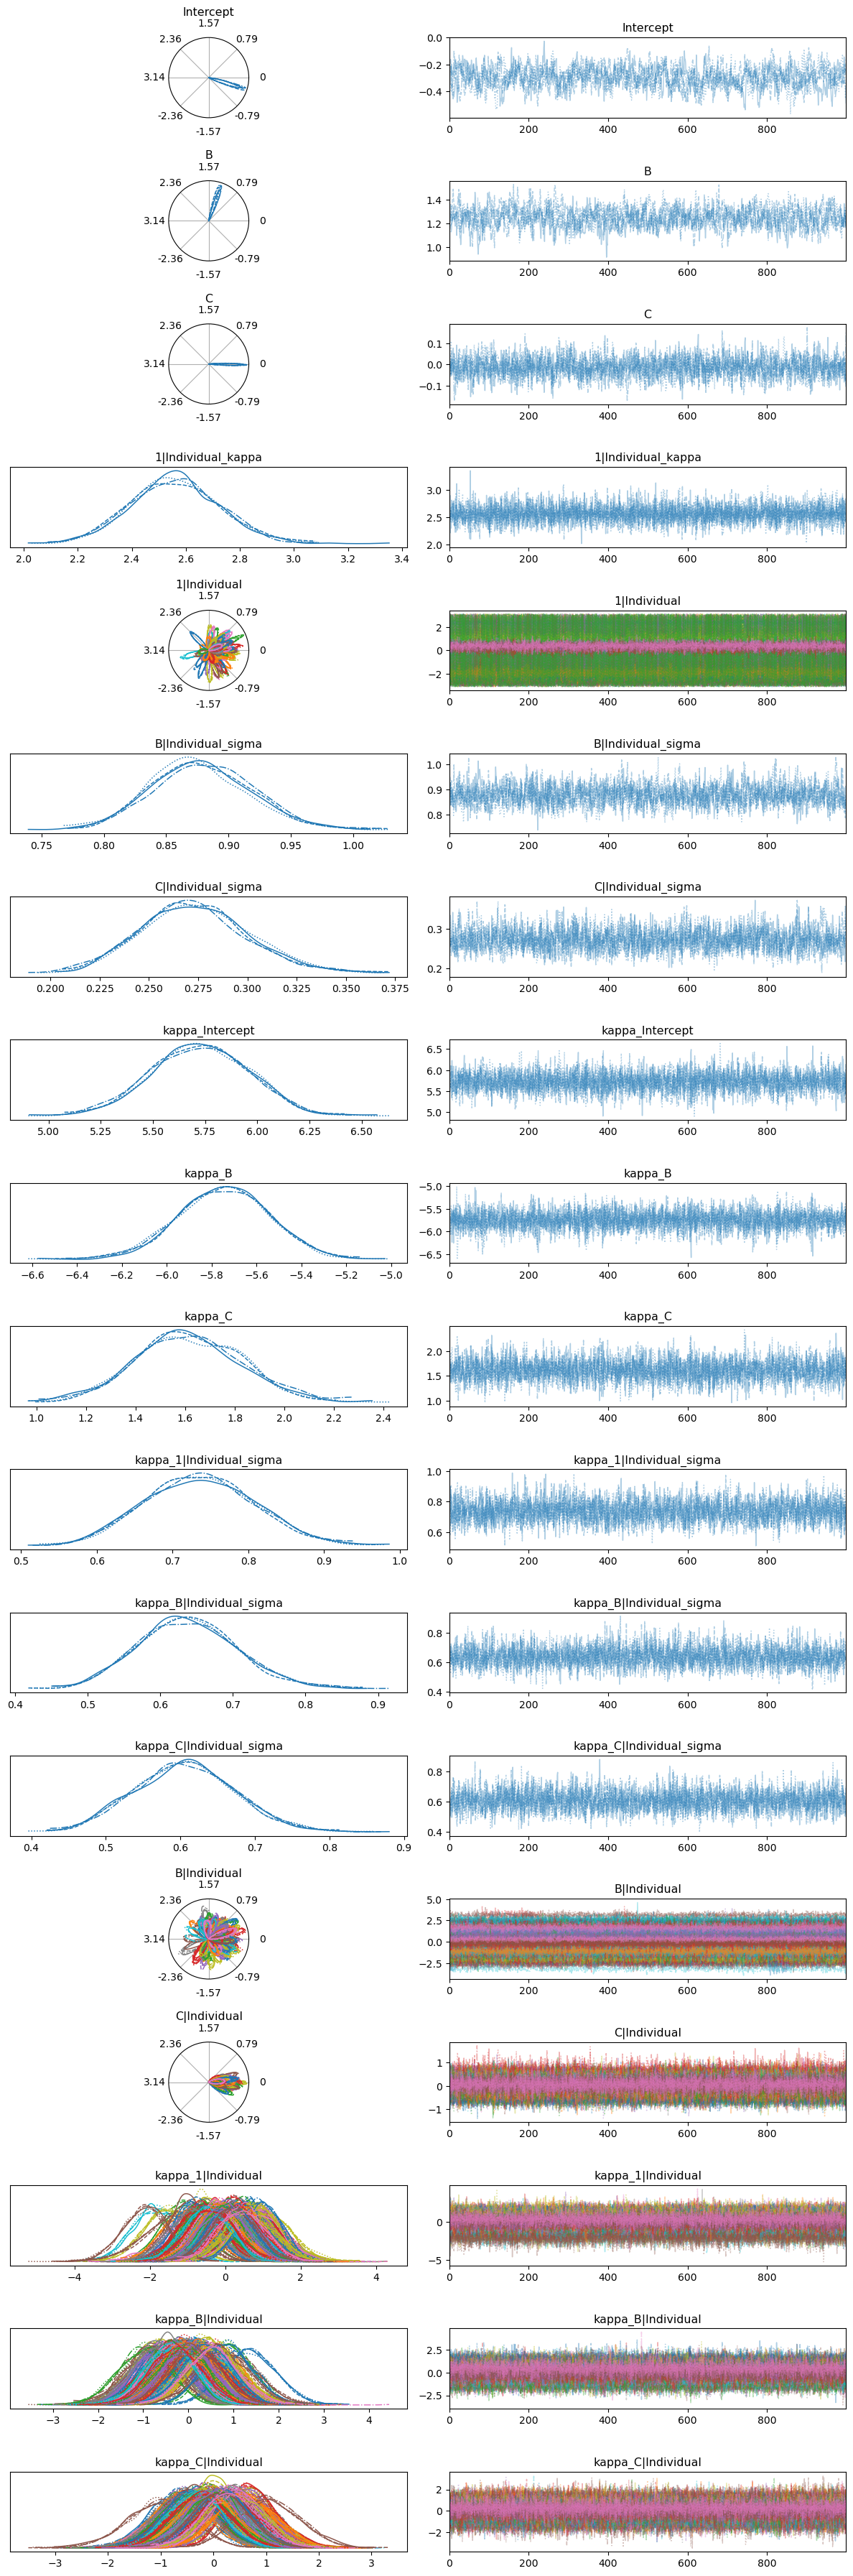

In [11]:

az.plot_trace(idata, circ_var_names=["Intercept",
                                     "B",
                                     "C",
                                     "1|Individual",
                                     "B|Individual",
                                     "C|Individual",
                                     ])
plt.tight_layout()
plt.show()

# Attempt a model with fixed effects interactions
To account for specific effects of the UV dim light that are separate from the effect of dimming the green light or switching from bright green to bright UV, include an interaction term.

In [ ]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_int = bmb.Formula(
    "angle ~ B + C + B:C + (1 + B + C |Individual)",
    "kappa ~ B + C + B:C + (1 + B + C |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_int = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "B:C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        "B:C": bmb.Prior("Normal", mu=0, sigma=2.5), # Jake reckons this prior should be smaller because it is an intercept with larger uncertainty
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_int = bmb.Model(
    formula_int,
    df,
    family="vonmises",
    priors=priors_int,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_int)

# Fit the model. 
idata_int = model_int.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!
#This version has the worst convergence, it may not make sense for the interaction to exist as only a fixed effect

       Formula: angle ~ B + C + B:C + (1 + B + C |Individual)
                kappa ~ B + C + B:C + (1 + B + C |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3142)
            C ~ Normal(mu: 0.0, sigma: 0.3142)
            B:C ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_B ~ Normal(mu: 0.0, sigma: 2.5)
            kappa_C ~ Normal(mu: 0.0, sigma: 2.5)
         

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, B:C, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_B:C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset]


/opt/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 467 seconds.
There were 411 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


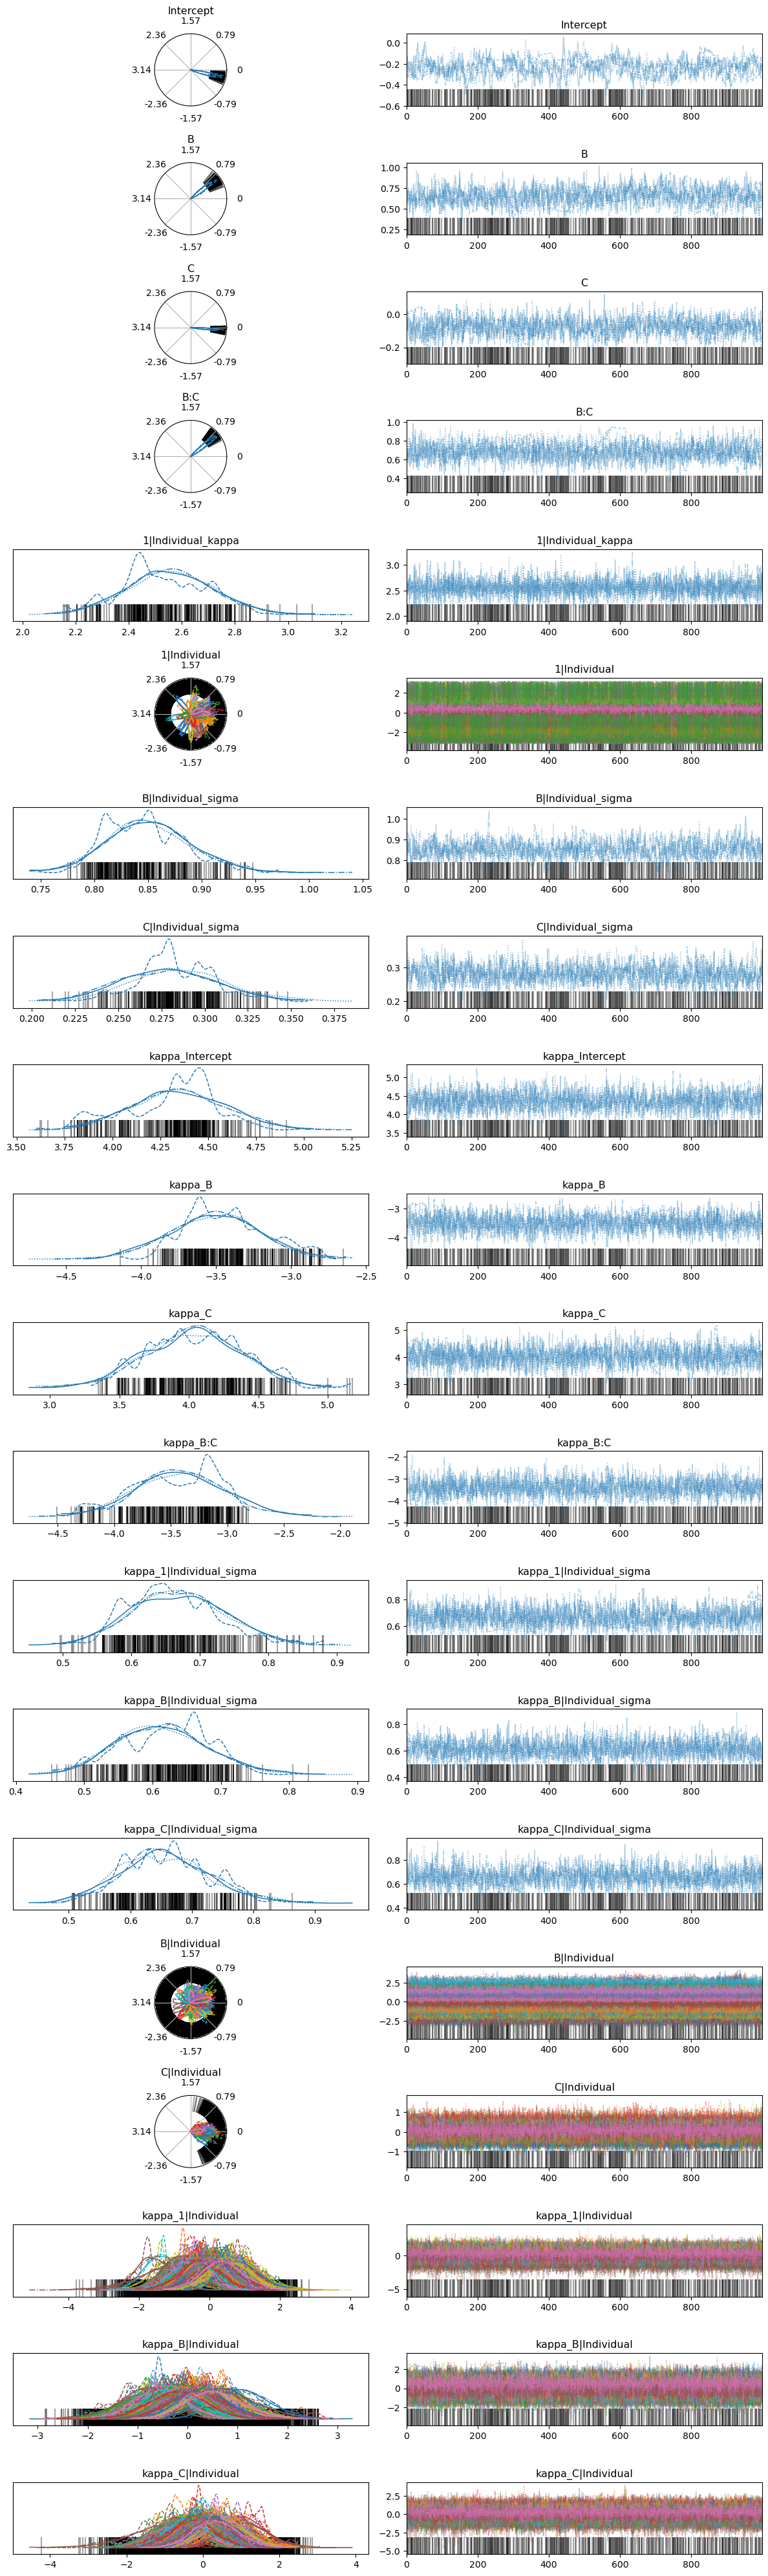

In [14]:

az.plot_trace(idata_int, circ_var_names=["Intercept",
                                     "B",
                                     "C",
                                     "B:C",
                                     "1|Individual",
                                     "B|Individual",
                                     "C|Individual",
                                     ])
plt.tight_layout()
plt.show()

# Attempt to fit a model with interactions in the random effects
Include the possibility for each individual bee to respond differently to the dim UV light.
This might be more challenging for the random-effects on mean angle.
Currently appears that it is just slower to run the additional parameters.
Expect this to take `~20` minutes for `1000` draws.

In [21]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_intID = bmb.Formula(
    "angle ~ B + C + B:C + (1 + B + C + B:C  |Individual)",
    "kappa ~ B + C + B:C + (1 + B + C + B:C  |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_intID = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "B:C": bmb.Prior("Normal", mu=0, sigma=0.05 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "B:C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        "B:C": bmb.Prior("Normal", mu=0, sigma=1.25), # Jake reckons this prior should be smaller because it is an intercept with larger uncertainty
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B:C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_intID = bmb.Model(
    formula_intID,
    df,
    family="vonmises",
    priors=priors_intID,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_intID)

# Fit the model.
idata_intID = model_intID.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!

       Formula: angle ~ B + C + B:C + (1 + B + C + B:C  |Individual)
                kappa ~ B + C + B:C + (1 + B + C + B:C  |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3142)
            C ~ Normal(mu: 0.0, sigma: 0.3142)
            B:C ~ Normal(mu: 0.0, sigma: 0.1571)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            B:C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
       

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, B:C, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, B:C|Individual_sigma, B:C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_B:C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset, kappa_B:C|Individual_sigma, kappa_B:C|Individual_offset]


/opt/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 851 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/miniconda3/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


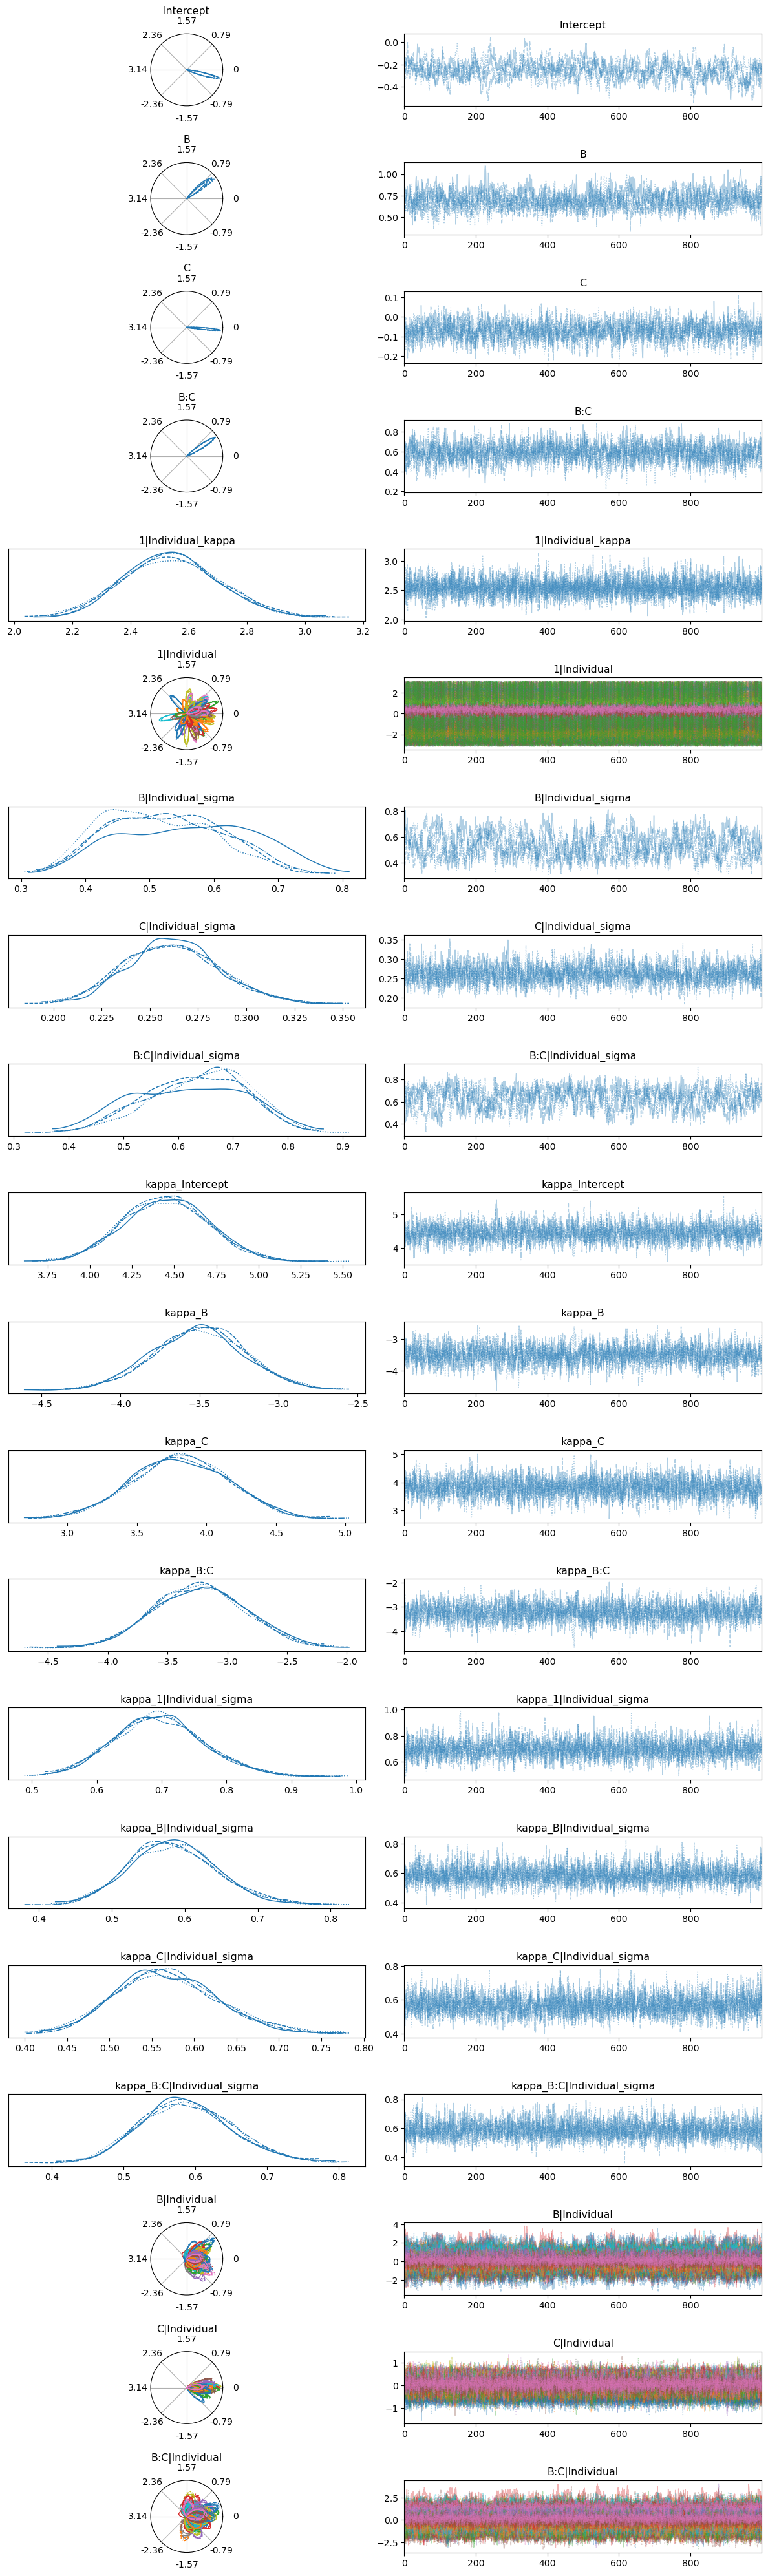

In [22]:

az.plot_trace(idata_intID, circ_var_names=["Intercept",
                                     "B",
                                     "C",
                                     "B:C",
                                     "1|Individual",
                                     "B|Individual",
                                     "C|Individual",
                                     "B:C|Individual",
                                     ])
plt.tight_layout()
plt.show()

In [23]:

az.summary(
    idata_intID, 
    var_names=["Intercept",
               "B",
                "C",
                "B:C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                "kappa_B:C",
                ],
    circ_var_names=["Intercept",
                    "B",
                    "C",
                    "B:C",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       -0.253  0.081  -0.407   -0.107      0.005    0.003     330.0   
B                0.694  0.105   0.505    0.892      0.011    0.011      51.0   
C               -0.071  0.047  -0.161    0.016      0.001    0.001    1249.0   
B:C              0.589  0.097   0.415    0.783      0.005    0.002    1185.0   
kappa_Intercept  4.453  0.249   4.004    4.938      0.005    0.004    2461.0   
kappa_B         -3.500  0.289  -4.067   -2.968      0.006    0.004    2393.0   
kappa_C          3.812  0.346   3.180    4.472      0.007    0.005    2452.0   
kappa_B:C       -3.229  0.379  -3.907   -2.500      0.008    0.006    2250.0   

                 ess_tail  r_hat  
Intercept           728.0   1.02  
B                   986.0   1.06  
C                  2681.0   1.00  
B:C                2223.0   1.01  
kappa_Intercept    3038.0   1.00  
kappa_B            2998.0   1.00  
kappa_C            2780.0   1.00  
kappa_B:C          2790.0   1.00

In [20]:

az.summary(
    idata_intID, 
    circ_var_names=["Intercept", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  \
Intercept                              -0.245  0.078  -0.385   -0.094   
B                                       0.695  0.101   0.514    0.894   
C                                      -0.072  0.048  -0.159    0.019   
B:C                                     0.578  0.096   0.393    0.754   
1|Individual_kappa                      2.547  0.164   2.240    2.847   
...                                       ...    ...     ...      ...   
kappa_B:C|Individual[2016.09.27.15.52] -0.291  1.055  -2.384    1.569   
kappa_B:C|Individual[2016.09.29.14.21] -0.747  1.049  -2.854    1.120   
kappa_B:C|Individual[2016.09.29.14.52] -0.001  0.988  -1.897    1.736   
kappa_B:C|Individual[2016.09.29.15.15]  0.467  1.040  -1.520    2.321   
kappa_B:C|Individual[2016.09.29.15.43]  1.666  1.142  -0.456    3.745   

                                        mcse_mean  mcse_sd  ess_bulk  \
Intercept                                   0.002    0.003     373.0   
B                                           0.005    0.004     371.0   
C                                           0.001    0.001    1218.0   
B:C                                         0.003    0.002    1086.0   
1|Individual_kappa                          0.002    0.002    4518.0   
...                                           ...      ...       ...   
kappa_B:C|Individual[2016.09.27.15.52]      0.015    0.015    4667.0   
kappa_B:C|Individual[2016.09.29.14.21]      0.016    0.015    4562.0   
kappa_B:C|Individual[2016.09.29.14.52]      0.016    0.016    3699.0   
kappa_B:C|Individual[2016.09.29.15.15]      0.015    0.015    5127.0   
kappa_B:C|Individual[2016.09.29.15.43]      0.017    0.014    4417.0   

                                        ess_tail  r_hat  
Intercept                                  849.0   1.01  
B                                         1279.0   1.02  
C                                         2258.0   1.00  
B:C                                       2128.0   1.00  
1|Individual_kappa                        2537.0   1.00  
...                                          ...    ...  
kappa_B:C|Individual[2016.09.27.15.52]    3078.0   1.00  
kappa_B:C|Individual[2016.09.29.14.21]    3364.0   1.00  
kappa_B:C|Individual[2016.09.29.14.52]    2901.0   1.00  
kappa_B:C|Individual[2016.09.29.15.15]    3172.0   1.00  
kappa_B:C|Individual[2016.09.29.15.43]    2993.0   1.00  

[1272 rows x 9 columns]

## Extract & inspect posterior samples

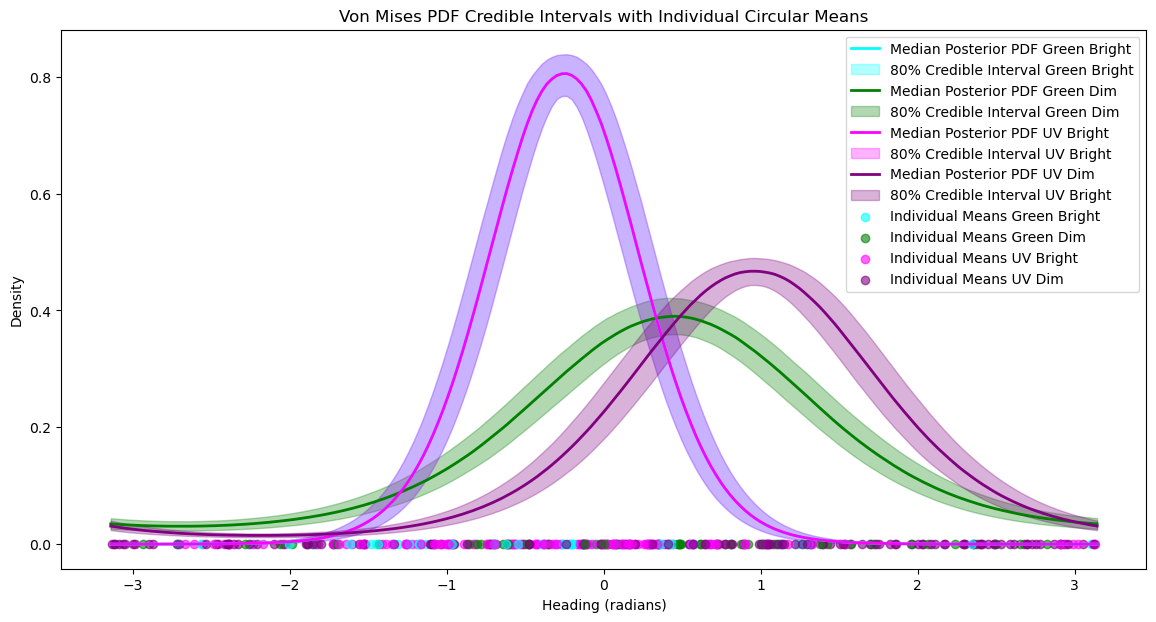

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_intID.posterior['Intercept'].values          # fixed intercept for μ
mu_slopeB    = idata_intID.posterior['B'].values               # fixed slope for μ # Not working?
mu_slopeC    = idata_intID.posterior['C'].values               # fixed slope for μ # Not the right name?
mu_slopeBC   = idata_intID.posterior['B:C'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_intID.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slopeB    = idata_intID.posterior['kappa_B'].values        # fixed slope for κ (linear predictor)
kappa_slopeC    = idata_intID.posterior['kappa_C'].values        # fixed slope for κ (linear predictor)
kappa_slopeBC   = idata_intID.posterior['kappa_B:C'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_gh_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_gl_samples_all  = shifted_modulo((mu_intercept + mu_slopeB).flatten())
mu_pop_uh_samples_all  = shifted_modulo((mu_intercept + mu_slopeC).flatten())
mu_pop_ul_samples_all  = shifted_modulo((mu_intercept + mu_slopeB + mu_slopeC + mu_slopeBC).flatten())
kappa_pop_gh_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_gl_samples_all  = softplus((kappa_intercept + kappa_slopeB).flatten())
kappa_pop_uh_samples_all  = softplus((kappa_intercept + kappa_slopeC).flatten())
kappa_pop_ul_samples_all  = softplus((kappa_intercept + kappa_slopeB + kappa_slopeC + kappa_slopeBC).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_gh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gh_samples_all[:, None],
    loc=mu_pop_gh_samples_all[:, None]
)
pdf_gl = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gl_samples_all[:, None],
    loc=mu_pop_gl_samples_all[:, None]
)
pdf_uh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_uh_samples_all[:, None],
    loc=mu_pop_uh_samples_all[:, None]
)
pdf_ul = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_ul_samples_all[:, None],
    loc=mu_pop_ul_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval. #JJF this appears to be the 80%CI!
median_pdf_gh = np.median(pdf_gh, axis=0)
lower_pdf_gh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_gh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_gl = np.median(pdf_gl, axis=0)
lower_pdf_gl  = np.percentile(pdf_gl, 10, axis=0)
upper_pdf_gl  = np.percentile(pdf_gl, 90, axis=0)

median_pdf_uh = np.median(pdf_gh, axis=0)
lower_pdf_uh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_uh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_ul = np.median(pdf_ul, axis=0)
lower_pdf_ul  = np.percentile(pdf_ul, 10, axis=0)
upper_pdf_ul  = np.percentile(pdf_ul, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_gh, color='cyan', lw=2, label='Median Posterior PDF Green Bright')
ax.fill_between(theta, lower_pdf_gh, upper_pdf_gh, color='cyan', alpha=0.3,
                label='80% Credible Interval Green Bright')

ax.plot(theta, median_pdf_gl, color='green', lw=2, label='Median Posterior PDF Green Dim')
ax.fill_between(theta, lower_pdf_gl, upper_pdf_gl, color='green', alpha=0.3,
                label='80% Credible Interval Green Dim')

ax.plot(theta, median_pdf_uh, color='magenta', lw=2, label='Median Posterior PDF UV Bright')
ax.fill_between(theta, lower_pdf_uh, upper_pdf_uh, color='magenta', alpha=0.3,
                label='80% Credible Interval UV Bright')

ax.plot(theta, median_pdf_ul, color='purple', lw=2, label='Median Posterior PDF UV Dim')
ax.fill_between(theta, lower_pdf_ul, upper_pdf_ul, color='purple', alpha=0.3,
                label='80% Credible Interval UV Bright')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_gh = individual_data.loc[(individual_data['B'] == 0) & (individual_data['C'] == 0), 'angle'].dropna()
    headings_gl = individual_data.loc[(individual_data['B'] == 1) & (individual_data['C'] == 0), 'angle'].dropna()
    headings_uh = individual_data.loc[(individual_data['B'] == 0) & (individual_data['C'] == 1), 'angle'].dropna()
    headings_ul = individual_data.loc[(individual_data['B'] == 1) & (individual_data['C'] == 1), 'angle'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_gh = shifted_modulo(circmean(headings_gh))
    individual_circmean_gl  = shifted_modulo(circmean(headings_gl))
    individual_circmean_uh = shifted_modulo(circmean(headings_uh))
    individual_circmean_ul  = shifted_modulo(circmean(headings_ul))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_gh, 0, color='cyan', alpha=0.6,
               label='Individual Means Green Bright' if i == 0 else "")
    ax.scatter(individual_circmean_gl, 0, color='green', alpha=0.6,
               label='Individual Means Green Dim' if i == 0 else "")
    ax.scatter(individual_circmean_uh, 0, color='magenta', alpha=0.6,
               label='Individual Means UV Bright' if i == 0 else "")
    ax.scatter(individual_circmean_ul, 0, color='purple', alpha=0.6,
               label='Individual Means UV Dim' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()

# Fit model including effect of sun azimuth
It seems likely that some dances may be for the same location, but shifting with the sun's location.
If I have understood correctly, circular–circular regression does not require any special syntax in the `unwrap` helper for `bambi`. 

In [34]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_intIDaz = bmb.Formula(
    "angle ~ B + C + B:C + SunAz + (1 + B + C + B:C |Individual)",
    "kappa ~ B + C + B:C + (1 + B + C + B:C |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_intIDaz = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "B:C": bmb.Prior("Normal", mu=0, sigma=0.05 * np.pi),
    "SunAz": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "B:C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        "B:C": bmb.Prior("Normal", mu=0, sigma=1.25), # Jake reckons this prior should be smaller because it is an intercept with larger uncertainty
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B:C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_intIDaz = bmb.Model(
    formula_intIDaz,
    df,
    family="vonmises",
    priors=priors_intIDaz,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_intIDaz)

# Fit the model.
idata_intIDaz = model_intIDaz.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!

       Formula: angle ~ B + C + B:C + SunAz + (1 + B + C + B:C |Individual)
                kappa ~ B + C + B:C + (1 + B + C + B:C |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3142)
            C ~ Normal(mu: 0.0, sigma: 0.3142)
            B:C ~ Normal(mu: 0.0, sigma: 0.1571)
            SunAz ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            B:C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
           

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, B:C, SunAz, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, B:C|Individual_sigma, B:C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_B:C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset, kappa_B:C|Individual_sigma, kappa_B:C|Individual_offset]


/opt/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 695 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [36]:

az.summary(
    idata_intIDaz, 
    var_names=["Intercept",
               "SunAz",
               "B",
                "C",
                "B:C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                "kappa_B:C",
                ],
    circ_var_names=["Intercept",
                    "SunAz",
                    "B",
                    "C",
                    "B:C",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       -0.318  0.112  -0.529   -0.110      0.003    0.003     770.0   
SunAz           -0.036  0.041  -0.114    0.040      0.001    0.001     838.0   
B                0.662  0.098   0.471    0.839      0.006    0.007     102.0   
C               -0.076  0.047  -0.166    0.010      0.001    0.001    2149.0   
B:C              0.563  0.097   0.379    0.741      0.008    0.005     169.0   
kappa_Intercept  4.451  0.250   3.941    4.881      0.004    0.003    3339.0   
kappa_B         -3.493  0.290  -4.040   -2.951      0.005    0.004    2985.0   
kappa_C          3.808  0.344   3.147    4.440      0.006    0.004    3611.0   
kappa_B:C       -3.224  0.371  -3.916   -2.527      0.007    0.005    3203.0   

                 ess_tail  r_hat  
Intercept          1312.0   1.01  
SunAz              1206.0   1.00  
B                   862.0   1.03  
C                  2462.0   1.00  
B:C                2436.0   1.02  
kappa_Intercept    2929.0   1.00  
kappa_B            3030.0   1.00  
kappa_C            3081.0   1.00  
kappa_B:C          2776.0   1.00

In [38]:

az.summary(
    idata_intIDaz, 
    circ_var_names=["Intercept", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  \
Intercept                              -0.318  0.112  -0.529   -0.110   
B                                       0.662  0.098   0.471    0.839   
C                                      -0.076  0.047  -0.166    0.010   
B:C                                     0.563  0.097   0.379    0.741   
SunAz                                  -0.036  0.041  -0.114    0.040   
...                                       ...    ...     ...      ...   
kappa_B:C|Individual[2016.09.27.15.52] -0.065  0.548  -1.117    0.936   
kappa_B:C|Individual[2016.09.29.14.21] -0.196  0.539  -1.210    0.837   
kappa_B:C|Individual[2016.09.29.14.52]  0.012  0.541  -1.040    0.984   
kappa_B:C|Individual[2016.09.29.15.15]  0.140  0.555  -0.918    1.133   
kappa_B:C|Individual[2016.09.29.15.43]  0.445  0.543  -0.552    1.497   

                                        mcse_mean  mcse_sd  ess_bulk  \
Intercept                                   0.003    0.003     770.0   
B                                           0.010    0.007     102.0   
C                                           0.001    0.001    2149.0   
B:C                                         0.007    0.005     169.0   
SunAz                                       0.001    0.001     838.0   
...                                           ...      ...       ...   
kappa_B:C|Individual[2016.09.27.15.52]      0.007    0.009    6914.0   
kappa_B:C|Individual[2016.09.29.14.21]      0.006    0.008    7563.0   
kappa_B:C|Individual[2016.09.29.14.52]      0.008    0.009    5101.0   
kappa_B:C|Individual[2016.09.29.15.15]      0.007    0.009    5727.0   
kappa_B:C|Individual[2016.09.29.15.43]      0.007    0.007    5814.0   

                                        ess_tail  r_hat  
Intercept                                 1312.0   1.01  
B                                          862.0   1.03  
C                                         2462.0   1.00  
B:C                                       2436.0   1.02  
SunAz                                     1206.0   1.00  
...                                          ...    ...  
kappa_B:C|Individual[2016.09.27.15.52]    3183.0   1.00  
kappa_B:C|Individual[2016.09.29.14.21]    3195.0   1.00  
kappa_B:C|Individual[2016.09.29.14.52]    3079.0   1.00  
kappa_B:C|Individual[2016.09.29.15.15]    2929.0   1.00  
kappa_B:C|Individual[2016.09.29.15.43]    2716.0   1.00  

[1273 rows x 9 columns]

## Extract & inspect posterior samples for sun azmimuth model

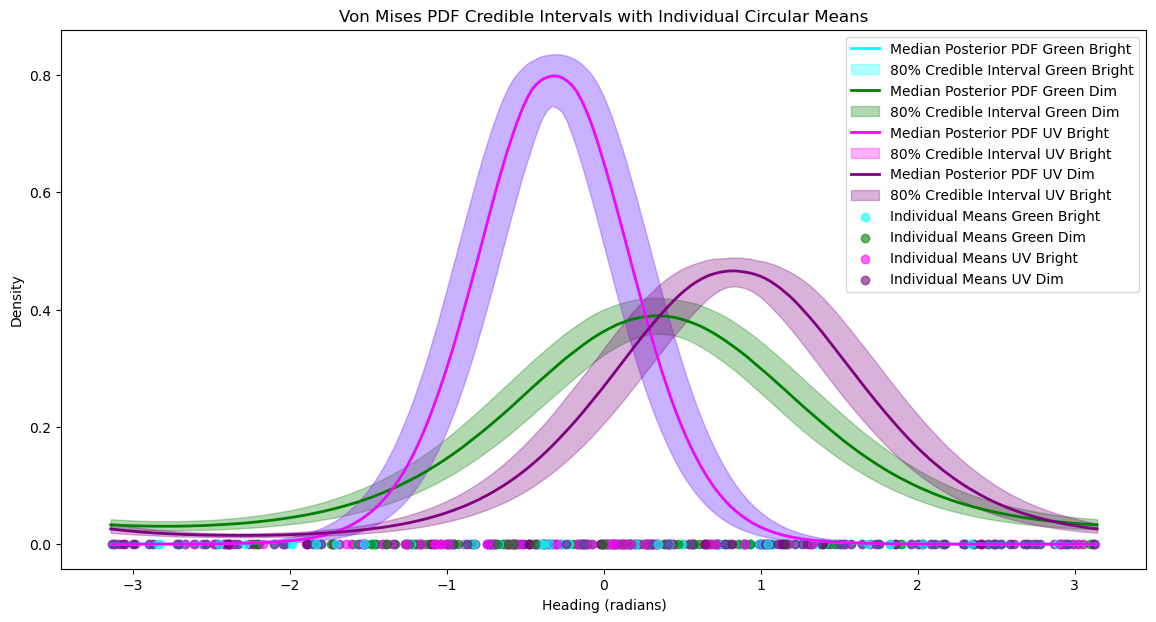

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_intIDaz.posterior['Intercept'].values          # fixed intercept for μ
mu_slopeB    = idata_intIDaz.posterior['B'].values               # fixed slope for μ # Not working?
mu_slopeC    = idata_intIDaz.posterior['C'].values               # fixed slope for μ # Not the right name?
mu_slopeBC   = idata_intIDaz.posterior['B:C'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_intIDaz.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slopeB    = idata_intIDaz.posterior['kappa_B'].values        # fixed slope for κ (linear predictor)
kappa_slopeC    = idata_intIDaz.posterior['kappa_C'].values        # fixed slope for κ (linear predictor)
kappa_slopeBC   = idata_intIDaz.posterior['kappa_B:C'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)*180/np.pi#in degrees

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_gh_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_gl_samples_all  = shifted_modulo((mu_intercept + mu_slopeB).flatten())
mu_pop_uh_samples_all  = shifted_modulo((mu_intercept + mu_slopeC).flatten())
mu_pop_ul_samples_all  = shifted_modulo((mu_intercept + mu_slopeB + mu_slopeC + mu_slopeBC).flatten())
kappa_pop_gh_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_gl_samples_all  = softplus((kappa_intercept + kappa_slopeB).flatten())
kappa_pop_uh_samples_all  = softplus((kappa_intercept + kappa_slopeC).flatten())
kappa_pop_ul_samples_all  = softplus((kappa_intercept + kappa_slopeB + kappa_slopeC + kappa_slopeBC).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_gh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gh_samples_all[:, None],
    loc=mu_pop_gh_samples_all[:, None]
)
pdf_gl = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gl_samples_all[:, None],
    loc=mu_pop_gl_samples_all[:, None]
)
pdf_uh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_uh_samples_all[:, None],
    loc=mu_pop_uh_samples_all[:, None]
)
pdf_ul = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_ul_samples_all[:, None],
    loc=mu_pop_ul_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval. #JJF this appears to be the 80%CI!
median_pdf_gh = np.median(pdf_gh, axis=0)
lower_pdf_gh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_gh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_gl = np.median(pdf_gl, axis=0)
lower_pdf_gl  = np.percentile(pdf_gl, 10, axis=0)
upper_pdf_gl  = np.percentile(pdf_gl, 90, axis=0)

median_pdf_uh = np.median(pdf_gh, axis=0)
lower_pdf_uh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_uh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_ul = np.median(pdf_ul, axis=0)
lower_pdf_ul  = np.percentile(pdf_ul, 10, axis=0)
upper_pdf_ul  = np.percentile(pdf_ul, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_gh, color='cyan', lw=2, label='Median Posterior PDF Green Bright')
ax.fill_between(theta, lower_pdf_gh, upper_pdf_gh, color='cyan', alpha=0.3,
                label='80% Credible Interval Green Bright')

ax.plot(theta, median_pdf_gl, color='green', lw=2, label='Median Posterior PDF Green Dim')
ax.fill_between(theta, lower_pdf_gl, upper_pdf_gl, color='green', alpha=0.3,
                label='80% Credible Interval Green Dim')

ax.plot(theta, median_pdf_uh, color='magenta', lw=2, label='Median Posterior PDF UV Bright')
ax.fill_between(theta, lower_pdf_uh, upper_pdf_uh, color='magenta', alpha=0.3,
                label='80% Credible Interval UV Bright')

ax.plot(theta, median_pdf_ul, color='purple', lw=2, label='Median Posterior PDF UV Dim')
ax.fill_between(theta, lower_pdf_ul, upper_pdf_ul, color='purple', alpha=0.3,
                label='80% Credible Interval UV Bright')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_gh = individual_data.loc[(individual_data['B'] == 0) & individual_data['C'] == 0, 'angle'].dropna()
    headings_gl = individual_data.loc[(individual_data['B'] == 1) & individual_data['C'] == 0, 'angle'].dropna()
    headings_uh = individual_data.loc[(individual_data['B'] == 0) & individual_data['C'] == 1, 'angle'].dropna()
    headings_ul = individual_data.loc[(individual_data['B'] == 1) & individual_data['C'] == 1, 'angle'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_gh = shifted_modulo(circmean(headings_gh))
    individual_circmean_gl  = shifted_modulo(circmean(headings_gl))
    individual_circmean_uh = shifted_modulo(circmean(headings_uh))
    individual_circmean_ul  = shifted_modulo(circmean(headings_ul))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_gh, 0, color='cyan', alpha=0.6,
               label='Individual Means Green Bright' if i == 0 else "")
    ax.scatter(individual_circmean_gl, 0, color='green', alpha=0.6,
               label='Individual Means Green Dim' if i == 0 else "")
    ax.scatter(individual_circmean_uh, 0, color='magenta', alpha=0.6,
               label='Individual Means UV Bright' if i == 0 else "")
    ax.scatter(individual_circmean_ul, 0, color='purple', alpha=0.6,
               label='Individual Means UV Dim' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()